In [11]:
import os
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
from ket_utilityP4 import *
%matplotlib inline
#steps
#1-calibration
#2-undistord
#3-color and gradient threshold
#4-perspective transform
debug_prt=1
debug_prt_=0
debug_im=1
debug_im_=0
debug_im_last=1
debug_save_img=1

In [12]:
#get the camera calibration parameters
#either from the file or from image processing 
if (os.path.isfile('P4CameraParam.p'))==True:
    # read python dict back from the file
    print('Reading Camera Parameters from file')
    pickle_file = open('P4CameraParam.p', 'rb')
    p4dict = pickle.load(pickle_file)
    ret=p4dict['ret']
    mtx=p4dict['mtx']
    dist=p4dict['dist']
    rvecs=p4dict['rvecs']
    tvecs=p4dict['tvecs']
    nx=p4dict['nx']
    nx=p4dict['ny']
    pickle_file.close()
else:
    print('Camera Param file not found!!')
    #number of corners in x and y directions
    nx=9
    ny=6
    #read the images
    cal_files='./camera_cal/calibration*.jpg'
    image_files=glob.glob(cal_files)
    #just to get image size
    dummy_img=cv2.imread('./camera_cal/calibration1.jpg')
    img_size=(dummy_img.shape[1], dummy_img.shape[0])
    #get the image and object points using utility function from ket_utilityP4
    imgpoints, objpoints=get_imagepoints_objpoints(image_files, gridsize=(nx, ny), debug_prt=0)
    ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(objpoints, imgpoints,img_size, None, None)
    p4dict = {'ret': ret, 'mtx': mtx, 'dist': dist, 'rvecs': rvecs, 'tvecs': tvecs, 'nx': nx, 'ny': ny}
    output = open('P4CameraParam.p', 'wb')
    pickle.dump(p4dict, output)
    output.close()

Reading Camera Parameters from file


image size (1280, 720)


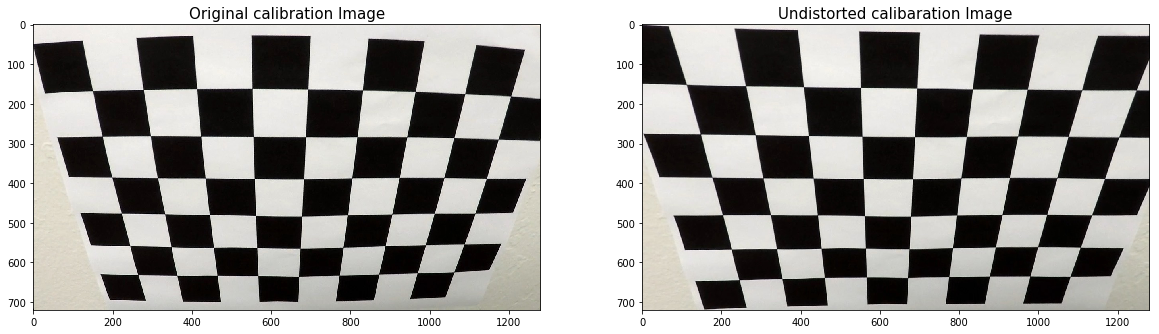

In [13]:
#test images can be loaded using files.
calfile0='./camera_cal/calibration2.jpg'
dummy_img=cv2.imread(calfile0)
img_size=(dummy_img.shape[1], dummy_img.shape[0])
print('image size', img_size)
dummy_img= cv2.cvtColor(dummy_img, cv2.COLOR_BGR2RGB)
undistorted_dummy_img = cv2.undistort(dummy_img, mtx, dist, None, mtx)
#
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dummy_img)
ax1.set_title('Original calibration Image', fontsize=15)
ax2.imshow(undistorted_dummy_img)
ax2.set_title('Undistorted calibaration Image', fontsize=15)
if debug_save_img:
    mpimg.imsave('./output_images/undistorted_calibration2.png', undistorted_dummy_img)

image size (1280, 720)


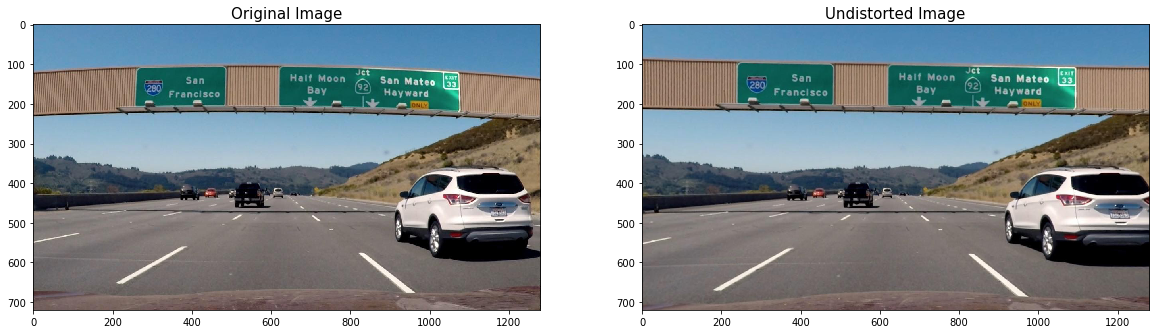

In [14]:
#test images can be loaded using files.
file0='./test_images/signs_vehicles_xygrad.png'
file1='./test_images/straight_lines1.jpg'
file2='./test_images/straight_lines2.jpg'
file3='./test_images/test1.jpg'
file4='./test_images/test2.jpg'
file5='./test_images/test3.jpg' 
file6='./test_images/test4.jpg' 
file7='./test_images/test5.jpg' 
file8='./test_images/test6.jpg'
dummy_img=cv2.imread(file0)
img_size=(dummy_img.shape[1], dummy_img.shape[0])
print('image size', img_size)
dummy_img= cv2.cvtColor(dummy_img, cv2.COLOR_BGR2RGB)
undistorted_dummy_img = cv2.undistort(dummy_img, mtx, dist, None, mtx)
#
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dummy_img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undistorted_dummy_img)
ax2.set_title('Undistorted Image', fontsize=15)
if debug_save_img:
    mpimg.imsave('./output_images/undistorted_signs_vehicles.png', undistorted_dummy_img)

(720, 1280, 3)


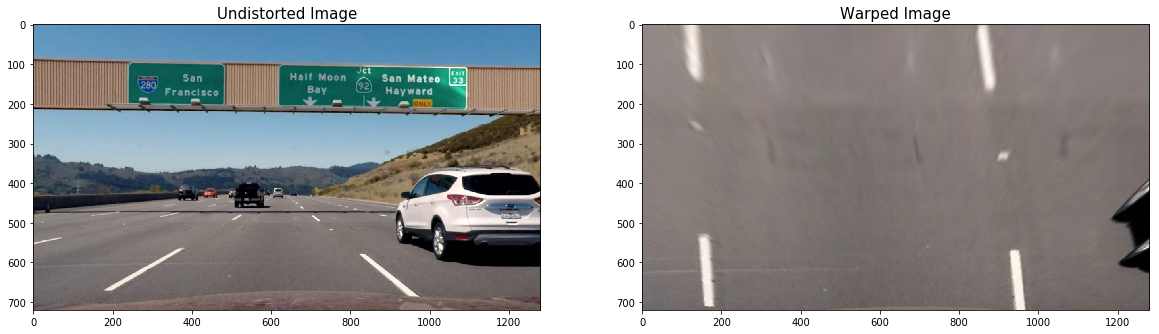

In [15]:
#get warped image using perspective transformation
#corner of the source
#left_bottom=[40,720]
left_bottom=[40,680]
left_top=[490,482]
right_top=[810,482]
#right_bottom=[1250,720]
right_bottom=[1250,680]
#source
src=np.float32([left_top, right_top, right_bottom, left_bottom])
#now destination
#slight skew in the rectangle
dst=np.float32([[0,0], [1280,0], [1250, 720],[40,720]])
#perspective transportmation  
M=cv2.getPerspectiveTransform(src, dst)
Minv=cv2.getPerspectiveTransform(dst, src)
#
warped = cv2.warpPerspective(undistorted_dummy_img, M, img_size, flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_dummy_img)
ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=15)
if debug_save_img:
    mpimg.imsave('./output_images/warped_undistorted_signs_vehicles.png', warped)
print(warped.shape)

In [16]:
def pipeline(img):
    # Gaussian Blur
    kernel_size = 7
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Get S channel from HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    
    return color_binary

(720, 1280)


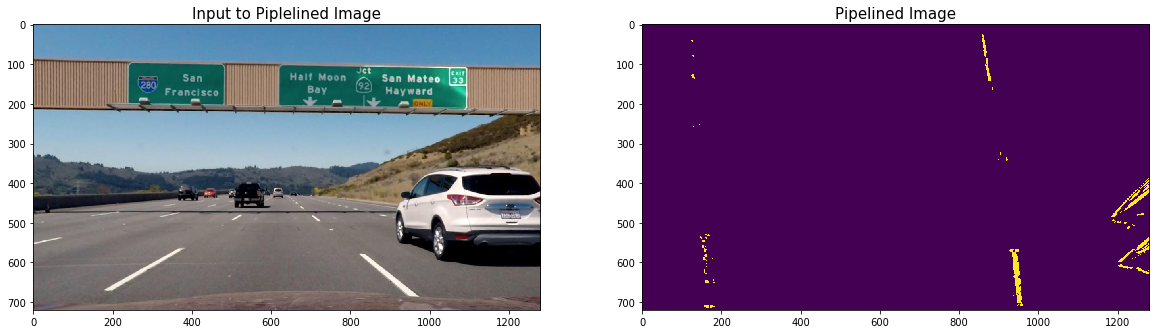

In [17]:
#get lanes using pipeline
piped_img = pipeline(warped)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_dummy_img)
ax1.set_title('Input to Piplelined Image', fontsize=15)
ax2.imshow(piped_img)
ax2.set_title('Pipelined Image', fontsize=15)
if debug_save_img:
    mpimg.imsave('./output_images/piplined_wrp_undist_signs_vehicles.png', piped_img)
print(piped_img.shape)

In [18]:
# Gaussian Blur
kernel_size = 7
img = cv2.GaussianBlur(warped, (kernel_size, kernel_size), 0)
# Get S channel from HLS color space
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s = hls[:,:,2]

# Grayscale image
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# Define sobel kernel size
ksize = 7
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
# Combine all the thresholding information
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# Threshold color channel
s_binary = np.zeros_like(combined)
s_binary[(s > 160) & (s < 255)] = 1
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors    
color_binary = np.zeros_like(combined)
color_binary[(s_binary > 0) | (combined > 0)] = 1

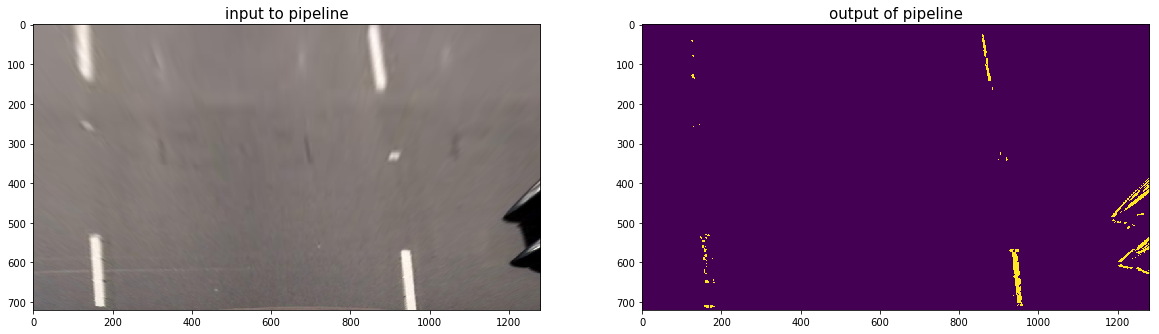

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped)
ax1.set_title('input to pipeline', fontsize=15)
ax2.imshow(color_binary)
ax2.set_title('output of pipeline', fontsize=15)


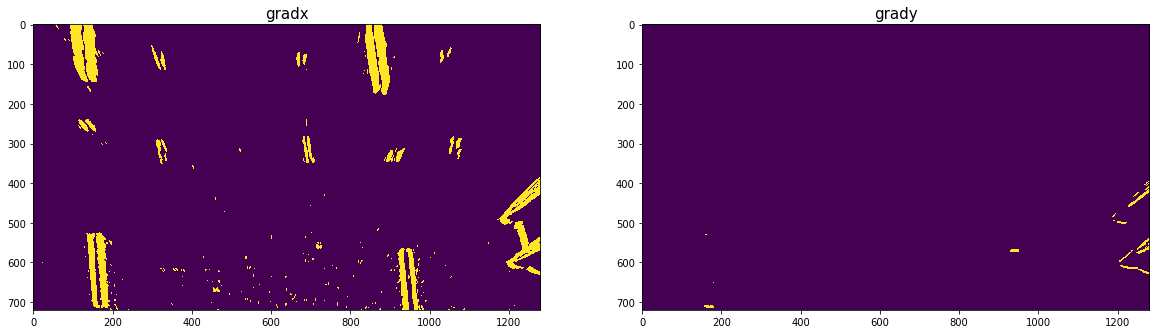

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(gradx)
ax1.set_title('gradx', fontsize=15)
ax2.imshow(grady)
ax2.set_title('grady', fontsize=15)

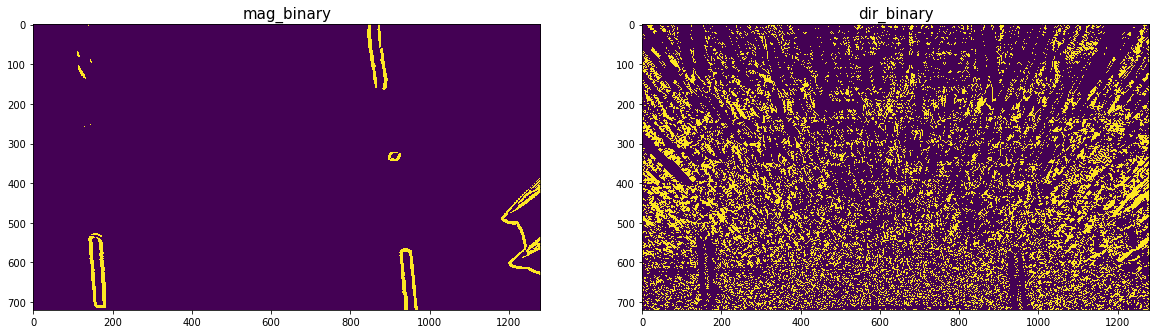

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(mag_binary)
ax1.set_title('mag_binary', fontsize=15)
ax2.imshow(dir_binary)
ax2.set_title('dir_binary', fontsize=15)

In [22]:
print(color_binary.shape, color_binary.max())

(720, 1280) 1.0


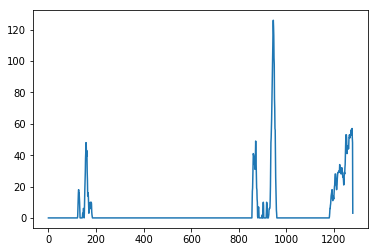

In [23]:
histogram = np.sum(color_binary[:,:], axis=0)
# Create an output image to draw on and  visualize the result
plt.clf()
plt.plot(histogram)

(720, 0)

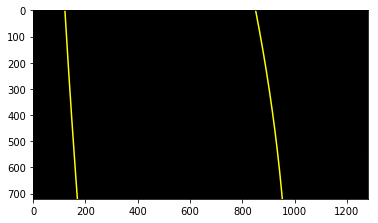

In [24]:
binary_warped=color_binary

midpoint = 640 #np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
#margin = 100
margin=100
# Set minimum number of pixels found to recenter window
#minpix=50
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(binary_warped,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(binary_warped,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)



# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255


out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#out_imgwarped_binary=bin_img_normal(warped_binary)
plt.clf()
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [25]:
if debug_prt_:
    print(right_fitx)

In [26]:
if debug_prt_:
    print(left_fitx)

In [27]:
print(len(left_fitx))

720


In [29]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(out_img).astype(np.uint8)
color_warp = warp_zero
print(warp_zero.shape)

(720, 1280, 3)


(720, 1280, 3)


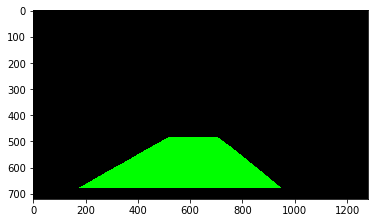

In [30]:
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (1280, 720))
print(newwarp.shape)
plt.imshow(newwarp)

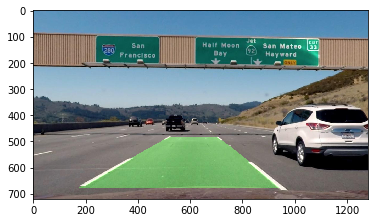

In [31]:

# Combine the result with the original image
result = cv2.addWeighted(undistorted_dummy_img, 1, newwarp, 0.3, 0)
plt.imshow(result)